In [41]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
from gensim.models import Word2Vec

In [42]:
def shuffle(data):
    for i in range(len(data)):
        j = np.random.randint(i, high=len(data))
        tmp = data[j]
        data[j] = data[i]
        data[i] = tmp

In [43]:
def get_walks(nodes, graph, length, n, metapaths):
    walks = []
    for node in nodes:  # iterate over root nodes
        filtered_metapaths = [metapath for metapath in metapaths if metapath[0] == graph.node[node]['label']]
        for metapath in filtered_metapaths:
            metapath = metapath[1:] * ((length // (len(metapath) - 1)) + 1)
            for walk_number in range(n):  # generate n walks per root node
                walk = []
                current_node = node
                for i in range(length):
                    walk.extend([current_node])
                    neighbours = list(graph.neighbors(current_node))
                    neighbours = [n for n in neighbours if graph.node[n]['label'] == metapath[i]]
                    if len(neighbours) == 0:
                        break
                    else:
                        rand_ix = np.random.randint(0, high=len(neighbours))
                        current_node = neighbours[rand_ix]  # select the first node to follow
                walks.append(walk)
    return walks

In [44]:
df = pd.read_csv('clicks_hashed.csv')
df.head()

,id,Click time,Ad id,Advertiser id,Site id,User id,User IP
0,0,1406977042,a3fbcd7e4b6362c75ab56687116a2433,510885b9a863ce0bd84b2ed3e58398f9,f9f32862920f6ca00c9725eade88f3d9,36b51acc9d3250851d0c0114aa04cc46,b1c7ac8696898d6f799e2f64c94156e6
1,1,1406977012,8683b0a8e3b4cac34cb40821e498ccdc,78ee95b2e2a854b40c714656b3f4321f,aa8e410642c0a8b95c53ea98a45c90b2,c6b363b3302908d1d6046d080df839e4,fd5cc76d2bfe24099c8777d557524b45
2,2,1406976966,8f8670b832c00cfd8493bca779aba942,e4551b0407c1cd88b24d367fc1ba4c5a,67877aff2349aa3053210af23632428f,0f2918a022fde0225b535988734461c4,39db42ae552c7c52dff1eb45d097bcab
3,3,1406976910,3437653362b4fab85ca9e147230208c5,478fb38eaeca30e36e1394411b2282a2,67877aff2349aa3053210af23632428f,bc605147700345892e6307ddfb4dedb6,10aa7a94cd916c9c6c1fa8c4cf22c92d
4,4,1406976857,a7e94defddbea68fb8cbc0885829a8b2,fcf373d8127ff67ac5501de0f6f80ec3,d2373599997dca05b50ade27578b8251,c32870919f9270d120cd58d68a957c18,0b0cad9116bb30d043be878866accd40


In [45]:
nx_graph = nx.Graph()
n_cols = len(df.columns)
for row in df.itertuples():
    vals_with_col_names = ['{}_{}'.format(df.columns[i], row[i + 1]) for i in range(len(df.columns))]
    for i in range(2, 6):
        nx_graph.add_node(vals_with_col_names[i], label=df.columns[i])
    nx_graph.add_edges_from([ 
        (vals_with_col_names[2], vals_with_col_names[3]),
        (vals_with_col_names[2], vals_with_col_names[4]),
        (vals_with_col_names[2], vals_with_col_names[5]),
    ]
        , time=row[2]
    )

In [47]:
labels = nx.get_node_attributes(nx_graph, 'label')

def get_degrees_by_label(nodes):
    degrees_by_label = dict([(col, []) for col in df.columns[2:6]])
    
    deg = nx_graph.degree
    for node in nodes:
        label = labels[node]
        degrees_by_label[labels[node]].append(nx_graph.degree(node))

    return degrees_by_label

In [73]:
def plot_degree_hist(nodes):
    plt.figure(figsize=(20,16))
    
    degrees_by_label = get_degrees_by_label(nodes)
    for i, col in enumerate(df.columns[2:6]):
        ax = plt.subplot(2, 2, i + 1)
        ax.set_title(col)
        plt.hist(np.array(degrees_by_label[col]), bins=40, density=True)
        

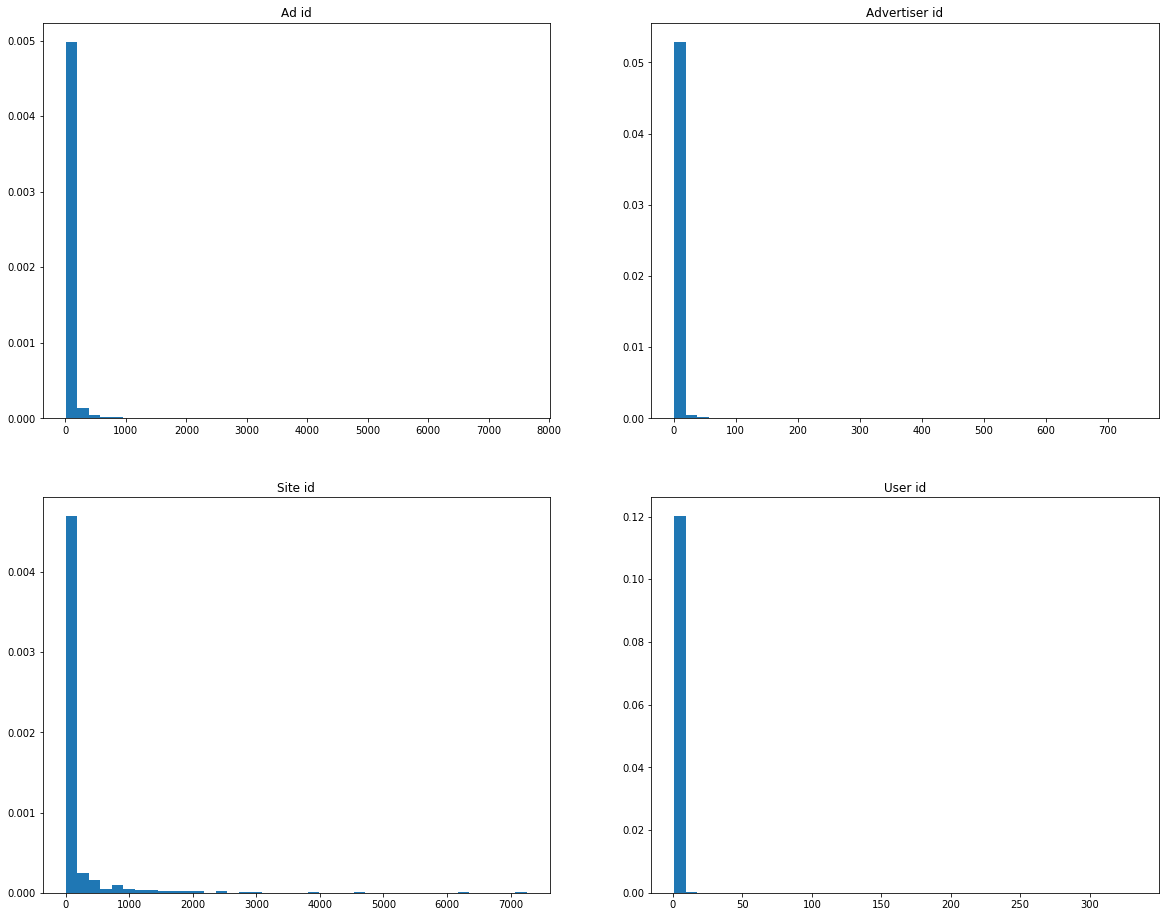

In [65]:
plot_degree_hist(nx_graph.nodes)

In [52]:
metapaths = [
    ["User id", "Ad id", "User id"],
    ["Ad id", "Advertiser id", "Ad id"],
    ["Advertiser id", "Ad id", "Site id", "Ad id", "Advertiser id"]
]
walks = get_walks(list(nx_graph.nodes()), nx_graph, 5, 5, metapaths)

model = Word2Vec(walks, size=12, window=5, min_count=0, sg=1, workers=2, iter=1)

In [59]:
def visualize(embeddings, color):
    tsne = TSNE(random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    ax = plt.gca()
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=color)

In [66]:
node_embeddings = [model.wv[n] for n in model.wv.index2word]
forest = IsolationForest(contamination=.01, random_state=42, behaviour='new')
outliers, inliers = [], []
outlier_flags = forest.fit_predict(node_embeddings)
for i, f in enumerate(outlier_flags):
    if f < 0:
        outliers.append(i)
    else:
        inliers.append(i)

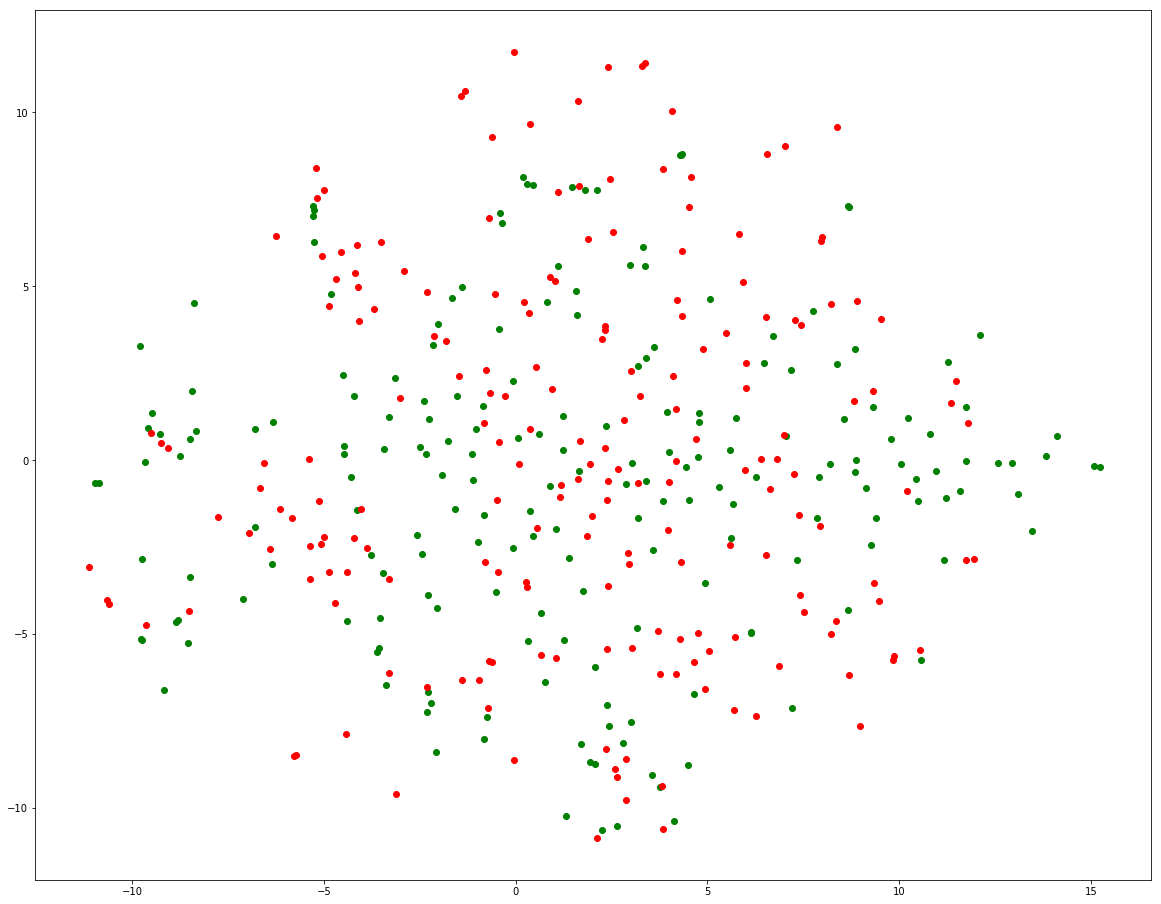

In [67]:
shuffle(inliers)
shuffle(outliers)
plt.figure(figsize=(20,16))
visualize([node_embeddings[i] for i in inliers[:200]], 'green')
visualize([node_embeddings[i] for i in outliers[:200]], 'red')

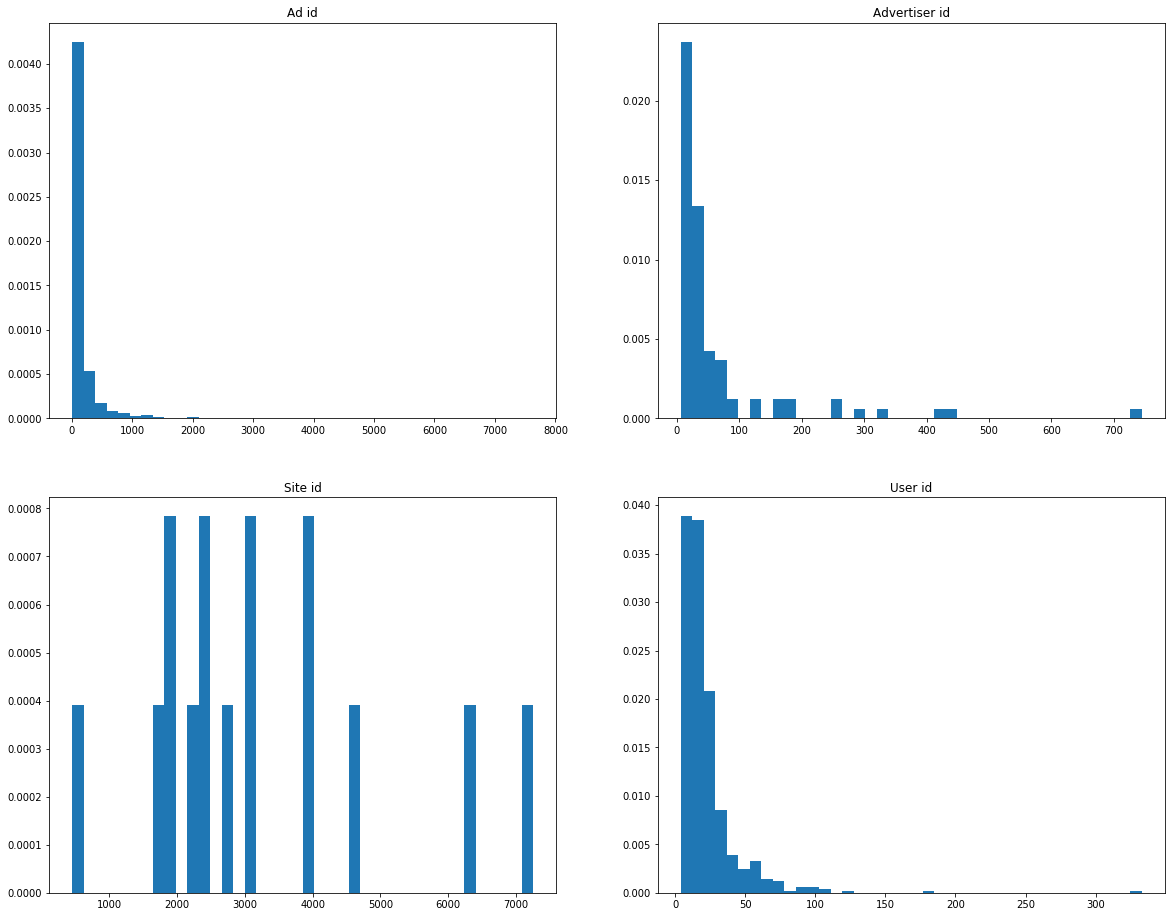

In [74]:
plot_degree_hist([model.wv.index2word[out_ix] for out_ix in outliers])